In [57]:
import json
import os
import random
import tkinter as tk

import matplotlib.pyplot as plt
import nltk
import numpy as np
import torch
from nltk.stem.porter import PorterStemmer
from torch.nn import CrossEntropyLoss, Linear, Module, ReLU
from torch.utils.data import DataLoader, Dataset
from wordcloud import WordCloud

### Utility functions

In [58]:
stemmer = PorterStemmer()

# Function to tokenize
tokenize = lambda x: nltk.word_tokenize(x)
# Function to perfomr stemming
stem = lambda x: stemmer.stem(x.lower())

# Function to extract Bag of Words
def bag_of_words(tokens, words):
    _words = [stem(word) for word in tokens]
    bag = np.zeros(len(words), dtype=np.float32)
    for idx, w in enumerate(words):
        if w in _words:
            bag[idx] = 1
    return bag

### Build our simple neural network

In [59]:
class NeuralNetwork(Module):
    def __init__(self, input_size, hidden_size, n_classes):
        super(NeuralNetwork, self).__init__()
        self.l1 = Linear(input_size, hidden_size)
        self.l2 = Linear(hidden_size, hidden_size)
        self.l3 = Linear(hidden_size, n_classes)
        self.relu = ReLU()

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        return self.l3(out)

In [60]:
dataset_path = os.path.join("dataset", "movies.json")
with open(dataset_path, "r") as f:
    movies = json.load(f)

all_words = []
tags = []
xy = []

# Loop through every sentence, tokenize each words, add to our word list and finally add to xy pair
for movie in movies.get("movies", []):
    tag = movie.get("tag", [])
    tags.append(tag)
    for pattern in movie.get("patterns", []):
        word = tokenize(pattern)
        all_words.extend(word)
        xy.append((word, tag))

In [61]:
# Stemming
to_ignore = ["?", ".", "!"]
all_words = [stem(x) for x in all_words if x not in to_ignore]

# Removing duplicates
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(all_words), "unique stemmed words:", all_words)

58 patterns
12 tags: ['action_movie', 'comedy movie', 'drama movie', 'favorite_movie', 'goodbye', 'greeting', 'horror_movie', 'recommendation', 'romance movie', 'sci_fi_movie', 'superhero_movie', 'thanks']
69 unique stemmed words: ["'m", "'s", ',', 'a', 'action', 'action-pack', 'all-tim', 'an', 'ani', 'anoth', 'appreci', 'are', 'bye', 'can', 'comedi', 'do', 'drama', 'dramat', 'enjoy', 'favorit', 'fine', 'for', 'futurist', 'good', 'goodby', 'have', 'heartwarm', 'hello', 'hey', 'hi', 'horror', 'how', 'i', 'in', 'is', 'it', 'later', 'like', 'look', 'lot', 'mood', 'most', 'movi', 'other', 'popular', 'realli', 'recommend', 'romanc', 'romant', 'scari', 'sci-fi', 'see', 'some', 'someth', 'suggest', 'superhero', 'talk', 'thank', 'that', 'the', 'there', 'to', 'want', 'watch', 'what', 'which', 'with', 'you', 'your']


In [62]:
# Initialize training data
X_train = []
y_train = []

In [63]:
# Add BOW to our training data
for pattern, tag in xy:
    bag = bag_of_words(pattern, all_words)
    X_train.append(bag)
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

### These are the hyperparameters we are going to use for our neural network

In [88]:
n_epochs = 1200
batch_size = 8
learning_rate = 0.0002
input_size = len(X_train[0])
hidden_size = 12
output_size = len(tags)

In [89]:
print(f"{input_size = }, {output_size = }")

input_size = 69, output_size = 12


### Our dataset class inherited from torch's dataset abstract class

In [90]:
class ChatDataset(Dataset):
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


In [91]:
# Init our dataset class
dataset = ChatDataset()

# Generate train dataset using DataLoader
train_loader = DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralNetwork(input_size, hidden_size, output_size).to(device)

criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Now, let's train our model

#### The device we are using consists of RTX 2060 Notebook GPU. So, we can see that cuda is supported :D

In [92]:
print("Available device: ", device)

Available device:  cuda


In [93]:
loss_history = []
acc_history = []

# Model training starts
for epoch in range(n_epochs):
    correct = 0
    total = 0
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        # if y would be one-hot, we must apply
        # labels = torch.max(labels, 1)[1]
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    if (epoch+1) % 100 == 0:
        loss_history.append(loss.item())
        acc = correct / total
        acc_history.append(acc)
        print (f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')


print(f'final loss: {loss.item():.4f}')


Epoch [100/2000], Loss: 2.4481, Accuracy: 0.2759
Epoch [200/2000], Loss: 1.8630, Accuracy: 0.4655
Epoch [300/2000], Loss: 0.9201, Accuracy: 0.8103
Epoch [400/2000], Loss: 0.7861, Accuracy: 1.0000
Epoch [500/2000], Loss: 0.5761, Accuracy: 1.0000
Epoch [600/2000], Loss: 0.0957, Accuracy: 1.0000
Epoch [700/2000], Loss: 0.0390, Accuracy: 1.0000
Epoch [800/2000], Loss: 0.0158, Accuracy: 1.0000
Epoch [900/2000], Loss: 0.0118, Accuracy: 1.0000
Epoch [1000/2000], Loss: 0.0118, Accuracy: 1.0000
Epoch [1100/2000], Loss: 0.0030, Accuracy: 1.0000
Epoch [1200/2000], Loss: 0.0030, Accuracy: 1.0000
Epoch [1300/2000], Loss: 0.0014, Accuracy: 1.0000
Epoch [1400/2000], Loss: 0.0015, Accuracy: 1.0000
Epoch [1500/2000], Loss: 0.0008, Accuracy: 1.0000
Epoch [1600/2000], Loss: 0.0003, Accuracy: 1.0000
Epoch [1700/2000], Loss: 0.0003, Accuracy: 1.0000
Epoch [1800/2000], Loss: 0.0001, Accuracy: 1.0000
Epoch [1900/2000], Loss: 0.0001, Accuracy: 1.0000
Epoch [2000/2000], Loss: 0.0003, Accuracy: 1.0000
final los

### Visualizing the accuracy and loss

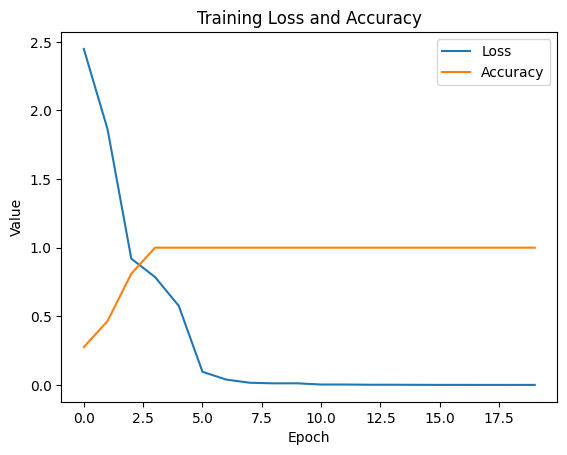

In [94]:
plt.plot(loss_history)
plt.plot(acc_history)
plt.legend(["Loss", "Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss and Accuracy")
plt.show()

## Word cloud to visualize most common words

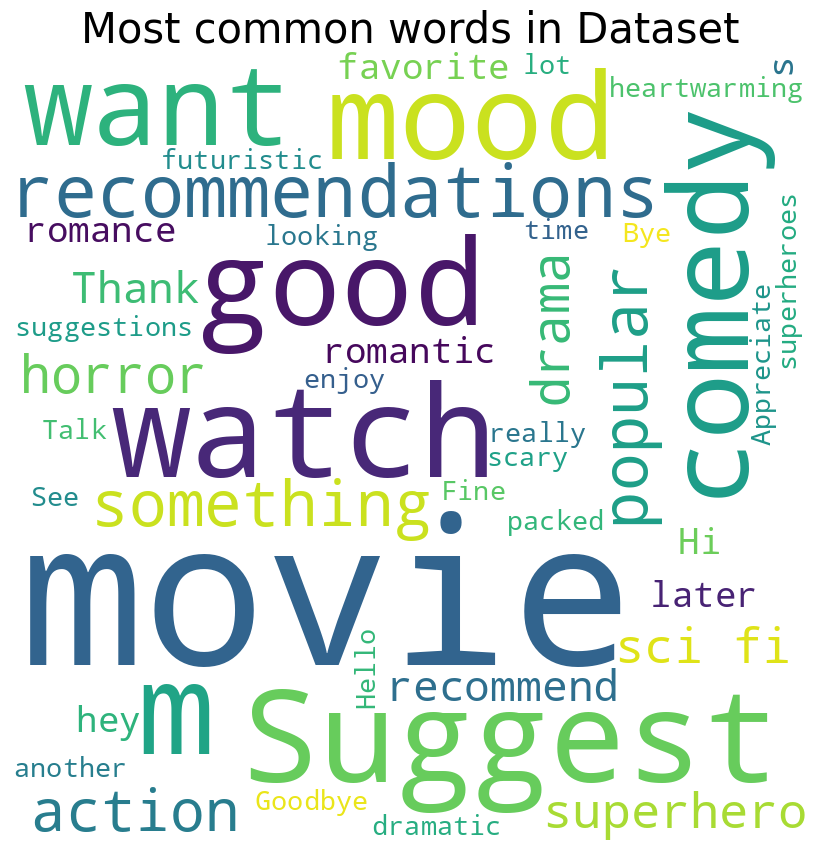

In [95]:
# Combine all patterns into one long string
all_patterns = ' '.join([' '.join(pattern) for pattern, _ in xy])

# Generate word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(all_patterns)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Most common words in Dataset', fontsize=30)
plt.show()


In [96]:
data = {
    "model_state": model.state_dict(),
    "input_size": input_size,
    "hidden_size": hidden_size,
    "output_size": output_size,
    "all_words": all_words,
    "tags": tags,
}

#### We are saving our trained model so that we can use it in future, and not only in runtime

In [97]:
FILE = "data.pth"
torch.save(data, FILE)
print(f"File has been saved to {FILE}")

File has been saved to model.pth


In [98]:
# Load intents from JSON file
with open(dataset_path, "r") as json_data:
    movies = json.load(json_data)

#### Run this codeblock if we need to load the model.

In [99]:
data = torch.load("data.pth")

# Extract variables from saved model
input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data["all_words"]
tags = data["tags"]
model_state = data["model_state"]

### Now, let's assemble our model using the loaded model configurations

In [100]:
model = NeuralNetwork(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

NeuralNetwork(
  (l1): Linear(in_features=69, out_features=12, bias=True)
  (l2): Linear(in_features=12, out_features=12, bias=True)
  (l3): Linear(in_features=12, out_features=12, bias=True)
  (relu): ReLU()
)

In [101]:
bot_name = "Too-Simple bot"

### Close any instance of chatbot if opened

In [102]:
def close_chatbot_window():
    root.destroy()

### Utility functions for chatbot

In [103]:
# Define function to get response from chatbot
def get_response(user_input):
    if user_input == "quit":
        close_chatbot_window()
        return
    sentence = tokenize(user_input)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)

    tag = tags[predicted.item()]

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
    if prob.item() > 0.75:
        for movie in movies["movies"]:
            if tag == movie["tag"]:
                response = random.choice(movie["responses"])
    else:
        response = "I do not understand..."
    return response

# Define function to update chat log
def update_chat_log(user_input, response):
    chat_log.config(state=tk.NORMAL)
    chat_log.insert(tk.END, "You: " + user_input + "\n\n")
    chat_log.insert(tk.END, bot_name + ": " + response + "\n\n")
    chat_log.config(state=tk.DISABLED)
    entry_box.delete(0, tk.END)


# Define function to handle user input
def handle_user_input(event):
    user_input = entry_box.get()
    response = get_response(user_input)
    update_chat_log(user_input, response)

# Interactive UI for chatbot

In [104]:
import tkinter as tk


def create_window():
    # Create tkinter window
    root = tk.Tk()
    root.title("Chatbot")
    return root


def create_chat_log(root):
    # Create chat log area
    chat_log = tk.Text(root, width=50, height=20, state=tk.DISABLED)
    chat_log.grid(row=0, column=0, padx=10, pady=10)
    return chat_log


def create_entry_box(root):
    # Create entry box for user input
    entry_box = tk.Entry(root, width=50)
    entry_box.grid(row=1, column=0, padx=10, pady=10)
    entry_box.bind("<Return>", handle_user_input)
    return entry_box


def create_send_button(root):
    # Create button for user input
    send_button = tk.Button(root, text="Send", command=lambda: handle_user_input(None))
    send_button.grid(row=1, column=1, padx=10, pady=10)
    return send_button


if __name__ == "__main__":
    # Start tkinter window
    root = create_window()
    chat_log = create_chat_log(root)
    entry_box = create_entry_box(root)
    send_button = create_send_button(root)
    root.mainloop()